In [ ]:
!pip install tensorflow==2.4.1

In [ ]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.3MB 8.7MB/s 


In [ ]:
!pip install -q -U tf-models-official==2.4

     |████████████████████████████████| 1.1MB 7.8MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 38.2MB 1.2MB/s 
     |████████████████████████████████| 686kB 29.8MB/s 
     |████████████████████████████████| 645kB 35.1MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 1.2MB 32.3MB/s 
     |████████████████████████████████| 174kB 51.6MB/s 
     |████████████████████████████████| 358kB 45.6MB/s 


In [ ]:
!pip install -U tfds-nightly

     |████████████████████████████████| 3.9MB 6.2MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from wordcloud import WordCloud,STOPWORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential,Model
tf.get_logger().setLevel('ERROR')
import math

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15009990617304195428
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1543516892743377345
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
di = '/content/drive/MyDrive/MP Dataset'
fake = pd.read_csv(di+'/Fake.csv')
real = pd.read_csv(di+'/True.csv')
fake['label'] = 1
real['label'] = 0
df = pd.concat([real,fake])
df.reset_index(inplace=True,drop=True)
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [ ]:
df.shape

(44898, 5)

Text(0.5, 1.0, 'Source of News')

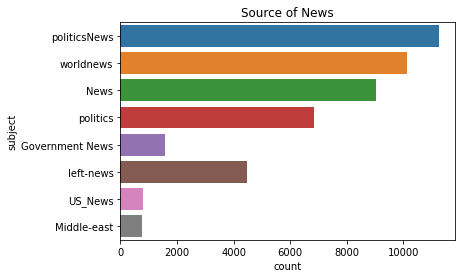

In [ ]:
sns.countplot(y='subject',data=df)
plt.title("Source of News")

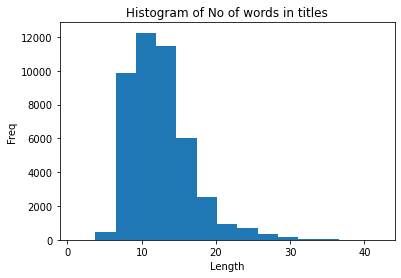

In [ ]:
plt.hist([len(x.split()) for x in df['title']],bins=15)
plt.title("Histogram of No of words in titles")
plt.xlabel("Length")
plt.ylabel("Freq")
plt.show()

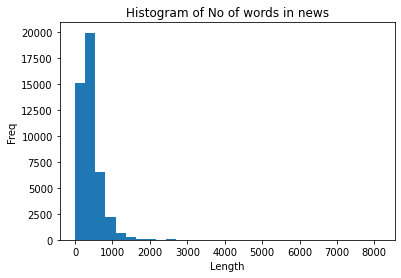

In [ ]:
plt.hist([len(x.split()) for x in df['text']],bins=30)
plt.title("Histogram of No of words in news")
plt.xlabel("Length")
plt.ylabel("Freq")
plt.show()

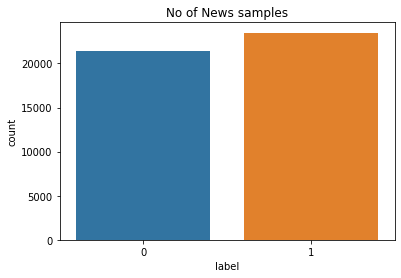

In [ ]:
# plt.figure(figsize=(16,8))
sns.countplot(x='label',data=df)

plt.title("No of News samples")

plt.show()


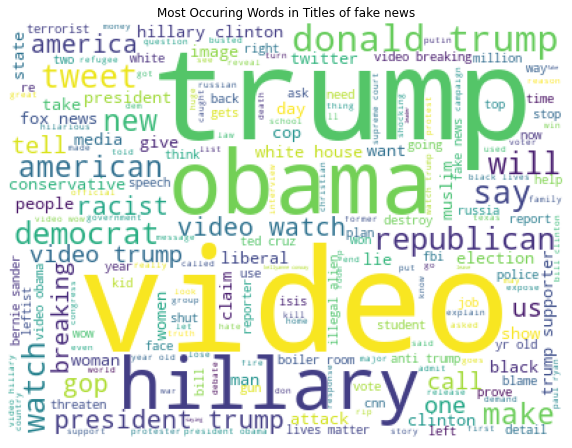

In [ ]:
twords = ' '.join(txt.lower() for txt in df.loc[df['label']==1,:].title)
stopwords = set(STOPWORDS)

plt.figure(figsize=(10,8))
wc = WordCloud(stopwords=stopwords,background_color='white',height=300).generate(twords)
plt.imshow(wc)
plt.axis('off')
plt.title("Most Occuring Words in Titles of fake news")
plt.show()

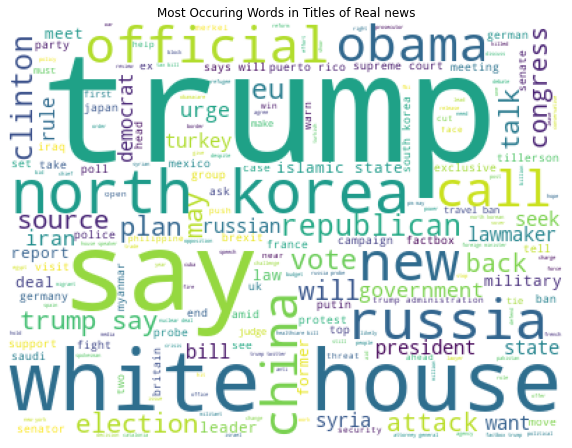

In [ ]:
twords = ' '.join(txt.lower() for txt in df.loc[df['label']==0,:].title)
stopwords = set(STOPWORDS)

plt.figure(figsize=(10,8))
wc = WordCloud(stopwords=stopwords,background_color='white',height=300).generate(twords)
plt.imshow(wc)
plt.axis('off')
plt.title("Most Occuring Words in Titles of Real news")
plt.show()

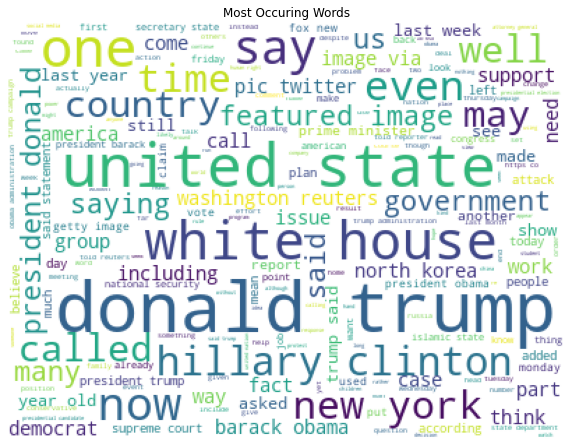

In [ ]:
words = ' '.join(txt.lower() for txt in df.text)
stopwords = set(STOPWORDS)

plt.figure(figsize=(10,8))
wc = WordCloud(stopwords=stopwords,background_color='white',height=300).generate(words)
plt.imshow(wc)
plt.axis('off')
plt.title("Most Occuring Words")
plt.show()

In [ ]:
df.text = df.text.str.replace("\s+"," ")
df.text = df.text.str.replace("[wW]{3}","")
df.text = df.text.str.replace("http\S+","")
df.text = df.text.str.replace("[^a-zA-Z\.\s\']","")
df.text = df.text.str.replace("\s+[a-zA-Z]\s+"," ")
df.text = df.text.str.replace("\w(\')\s|\s(\')\w'",'')


In [ ]:
df.title = df.title.str.replace("\s+"," ")
df.title = df.title.str.replace("[wW]{3}","")
df.title = df.title.str.replace("http\S+","")
df.title = df.title.str.replace("[^a-zA-Z\.\s\']","")
df.title = df.title.str.replace("\s+[a-zA-Z]\s+"," ")
df.title = df.title.str.replace("\w(\')\W|\W(\')\w'",'')

In [ ]:
train,test = train_test_split(df,train_size=0.8,random_state=1,shuffle=True)

In [ ]:
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace = True,drop=True)
train.head()

,title,text,subject,date,label
0,Iran nuclear deal must change if U.S. to stay ...,UNITED NATIONS Reuters The Iran nuclear deal ...,worldnews,"September 19, 2017",0
1,Donald Trump Tried To Manipulate Stock Market...,Donald Trump hates Jeff Bezos the CEO of Amazo...,News,"August 16, 2017",1
2,NEW POLL SHOWS DEMOCRATS Under Prefer Old Whi...,Nah nah nah nah hey hey hey good bye Support f...,politics,"Jan 20, 2016",1
3,Bigot Christians Make HILARIOUSLY AWFUL AntiT...,Ever since Target decided to stand up to trans...,News,"May 24, 2016",1
4,Google Maps HILARIOUSLY Trolls Trump Hell Be...,Donald Trump pride and joy is the tacky gaudy ...,News,"November 26, 2016",1


In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['hello world']))
tok

<tf.RaggedTensor [[[7592], [2088]]]>

In [ ]:
MAX_LEN = max([len(x.split()) for x in train.title])
MAX_LEN

40

In [ ]:
text_preprocessed = bert_preprocess.bert_pack_inputs([tok], tf.constant(20))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[ 101 7592 2088  102    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [ ]:
tfhub_handle_encoder

'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

In [ ]:
def preprocess_texts(input_string,seq_length = MAX_LEN):
  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=i)
      for i in input_string]

  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(segments)
  
  return tf.keras.Model(input_segments, model_inputs)


In [ ]:
model_preprocessor = preprocess_texts(['string1'])

In [ ]:
model_preprocessor(np.array(["The golden retriever loved the fireworks each Fourth of July."]))

{'input_mask': <tf.Tensor: shape=(1, 40), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1, 40), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(1, 40), dtype=int32, numpy=
 array([[  101,  1996,  3585, 12850,  2099,  3866,  1996, 16080,  2169,
          2959,  1997,  2251,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]], dtype=int32)>}

In [ ]:
def text_classifier(num_classes,model_preprocessor):
  inputs = model_preprocessor.input
  x = model_preprocessor(inputs)
  bert_encoder = hub.KerasLayer(tfhub_handle_encoder,trainable=True,name = 'bert_encoder')
  x = bert_encoder(x)
  cls = x['pooled_output']
  cls = tf.keras.layers.LayerNormalization()(cls)
  cls = tf.keras.layers.Dense(512,activation='relu')(cls)
  cls = tf.keras.layers.Dropout(0.2)(cls)
  out = tf.keras.layers.Dense(num_classes,activation = 'softmax')(cls)
  return tf.keras.Model(inputs,out)


In [ ]:
model = text_classifier(2,model_preprocessor)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
string1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
model (Functional)              {'input_word_ids': ( 0           string1[0][0]                    
__________________________________________________________________________________________________
bert_encoder (KerasLayer)       {'encoder_outputs':  28763649    model[0][0]                      
                                                                 model[0][1]                      
                                                                 model[0][2]                      
____________________________________________________________________________________________

In [ ]:
model(np.array(['The golden retriever loved the fireworks each Fourth of July.'])).numpy()

array([[0.33884743, 0.66115254]], dtype=float32)

In [ ]:
xtitle = train[['title']].to_numpy()
ytitle = train[['label']].to_numpy()
xval = test[['title']].to_numpy()
yval = test[['label']].to_numpy()
print(xtitle[:5])
ytitle[:5]

[['Iran nuclear deal must change if U.S. to stay Tillerson']
 [' Donald Trump Tried To Manipulate Stock Market Against One American Company It Worked For Few Hours']
 ['NEW POLL SHOWS DEMOCRATS Under  Prefer Old White Marxists To Serial Criminals In Pants Suits']
 [' Bigot Christians Make HILARIOUSLY AWFUL AntiTrans Music Video To Boycott Target VIDEO']
 [' Google Maps HILARIOUSLY Trolls Trump  Hell Be FURIOUS IMAGES']]


array([[0],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
model.save('/content/drive/MyDrive/MP4')

In [ ]:
model.load_weights('/content/drive/MyDrive/MP4/weights.03-0.980.ckpt')

In [ ]:
epochs = 3
batch_size = 32
init_lr = 2e-5
steps_per_epoch = xtitle.shape[0]//batch_size
train_steps = steps_per_epoch*epochs
warmup_steps = train_steps//10
optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=train_steps,
      num_warmup_steps=warmup_steps,
      optimizer_type='adamw')

callback = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/MP4/weights.{epoch:02d}-{val_acc:.3f}.ckpt',monitor='val_acc',save_weights_only=True)]
model.compile(optimizer=optimizer,loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['acc'])



In [ ]:
hist = model.fit(xtitle,ytitle,batch_size=batch_size,epochs=epochs,callbacks=callback,validation_data=(xval,yval))

Epoch 1/3
1123/1123 [==============================] - 123s 105ms/step - loss: 0.3537 - acc: 0.8223 - val_loss: 0.0802 - val_acc: 0.9710
Epoch 2/3
1123/1123 [==============================] - 118s 105ms/step - loss: 0.0807 - acc: 0.9720 - val_loss: 0.0727 - val_acc: 0.9782
Epoch 3/3
1123/1123 [==============================] - 118s 106ms/step - loss: 0.0563 - acc: 0.9830 - val_loss: 0.0736 - val_acc: 0.9800


In [ ]:
model.evaluate(xval,yval,batch_size=batch_size)

281/281 [==============================] - 18s 62ms/step - loss: 0.0736 - acc: 0.9800


[0.073581762611866, 0.9799554347991943]

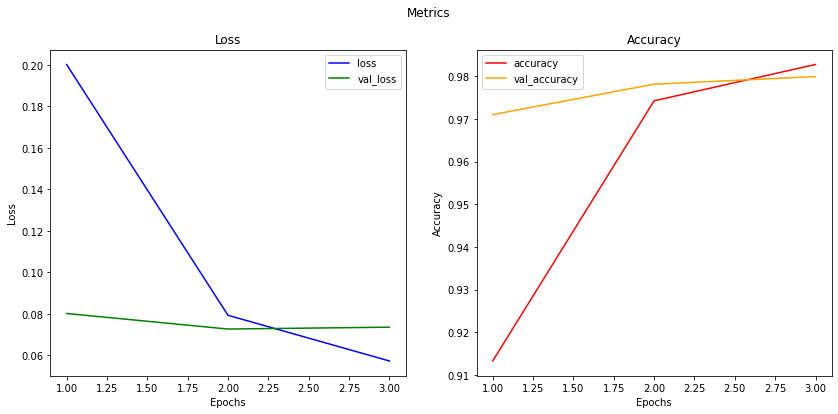

In [ ]:
loss = hist.history['loss']
acc=  hist.history['acc']
val_loss = hist.history['val_loss']
val_acc = hist.history['val_acc']

plt.figure(figsize=(14,6))
plt.title("Metrics")
plt.subplot(121)
plt.plot(range(1,epochs+1),loss,color='blue')
plt.plot(range(1,epochs+1),val_loss,color='green')
plt.legend(labels = ['loss','val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.subplot(122)
plt.plot(range(1,epochs+1),acc,color='red')
plt.plot(range(1,epochs+1),val_acc,color='orange')
plt.legend(labels = ['accuracy','val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.suptitle("Metrics")
plt.show()

In [ ]:
def ypred(xval,model):
  y = model.predict(xval)
  y = np.argmax(y,axis=1)
  return y
lis = ['Real','Fake']

def predict(x,model):
  x = np.array(x)
  if x.shape[0]<2:
    x = np.expand_dims(x,axis=0)
  y = model.predict(x)
  y = np.apply_along_axis(lambda x:lis[np.argmax(x)],1,y).squeeze()
  return y.tolist()

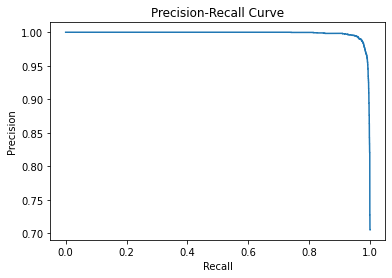

In [ ]:
from sklearn.metrics import precision_recall_curve
y_pred = model.predict(xval)
precision,recall,thresholds = precision_recall_curve(yval,y_pred[:,1])

plt.plot(recall,precision)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


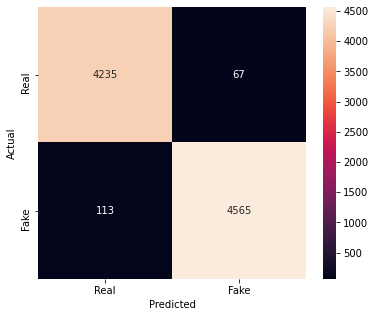

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import pandas as pd

yval_pred = ypred(xval,model)
cm = confusion_matrix(yval,yval_pred)
plt.figure(figsize=(6,5))
df = pd.DataFrame(cm,index = ['Real','Fake'],columns=['Real','Fake'])
sns.heatmap(df,annot=True,fmt = 'd')
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

In [ ]:
df

,Real,Fake
Real,4235,67
Fake,113,4565


In [ ]:
print(classification_report(yval,yval_pred,target_names=['Real','Fake']))

              precision    recall  f1-score   support

        Real       0.97      0.98      0.98      4302
        Fake       0.99      0.98      0.98      4678

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [ ]:
predict(['Twitter Cracks Down On Misinformation Over Vaccine, Begins Labelling Tweets',
         'Donald Trump Tried To Manipulate Stock Market Against One American Company It Worked For Few Hours',
         'North Korea seen moving missiles from development center South Korean broadcaster',
         'Bombs kill Pakistani soldiers hunting U.S.Canadian family\'s kidnappers',
         'Mamata Banerjee wins Bengal, but loses Nandigram to Suvendu Adhikari',
         'Google Maps HILARIOUSLY Trolls Trump  Hell Be FURIOUS IMAGES',
         'Consider Lockdown To Curb 2nd Covid Wave: Supreme Court To Centre, States'],model)

['Fake', 'Fake', 'Real', 'Real', 'Real', 'Fake', 'Real']

In [ ]:
train.loc[train['label']==1,'title'].head().to_numpy()

array([' Donald Trump Tried To Manipulate Stock Market Against One American Company It Worked For Few Hours',
       'NEW POLL SHOWS DEMOCRATS Under  Prefer Old White Marxists To Serial Criminals In Pants Suits',
       ' Bigot Christians Make HILARIOUSLY AWFUL AntiTrans Music Video To Boycott Target VIDEO',
       ' Google Maps HILARIOUSLY Trolls Trump  Hell Be FURIOUS IMAGES',
       'BREAKING Wikileaks Releases Vault  Part   Year Zero'],
      dtype=object)

In [ ]:
model.predict(np.array(['Donald Trump Tried To Manipulate Stock Market Against One American Company It Worked For Few Hours','Donald Trump Tried To Manipulate Stock Market Against One American Company It Worked For Few Hours']))

array([[1.7657653e-04, 9.9982351e-01],
       [1.7657653e-04, 9.9982351e-01]], dtype=float32)